<h1>ZMGSN Lista 3. - Normalizing Flows (NF)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu NICE (ang. Non-linear Independent Components Estimation)</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu NICE</li> (25pkt)
<li>Dokonać modyfikacji architektury modelu NICE w celu zbadania wpływu architektury na wyniki</li> (15pkt)
<li>Dokonać ewaluacji innych wariantów sieci opartych o przepływy normalizacyjne, np. ConvFlow, MAF, IAF itp.</li> (30pkt)
<li>Opracować procedurę ewaluacji jakości działania modelu NICE i innych rozważanych wariantów, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>
</ol> (30pkt)

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

from keras.datasets.mnist import load_data
from tqdm import tqdm
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform
from torch.utils.data import DataLoader

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [2]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [3]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie, rozpakowanie i normalizacja zbioru danych</h2>

In [4]:
(trainX, trainY), (testX, testy) = load_data()
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

11490434/11490434 [==============================] - 0s 0us/step


<h2>Deklaracja podstawowej klasy modelu NICE (ang. Non-linear Independent Component Estimation)<h2>

In [5]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

<h2>Definicja klasy reprezentującej standardowy rozkład logistyczny</h2>

In [6]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        return self.m.sample()

<h2>Przykładowa pętla ucząca</h2>

In [11]:
def training(normalizing_flow, optimizer, dataloader, distribution, epochs=1500, device='cpu'):
    training_loss = []
    for epoch in tqdm(range(epochs)):
        loss_list = []
        for batch in dataloader:
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            loss_list.append(loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")

    return training_loss

<h2>Inicjalizacja sieci NICE i uruchomienie procesu uczenia</h2>

In [12]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  7%|▋         | 1/15 [00:29<06:57, 29.85s/it]

Epoch [1/15], avg_loss: 31467.2849


 13%|█▎        | 2/15 [01:00<06:35, 30.43s/it]

Epoch [2/15], avg_loss: 22504.3267


 20%|██        | 3/15 [01:33<06:17, 31.43s/it]

Epoch [3/15], avg_loss: 14027.3734


 27%|██▋       | 4/15 [02:02<05:36, 30.58s/it]

Epoch [4/15], avg_loss: 6019.0028


 33%|███▎      | 5/15 [02:33<05:05, 30.56s/it]

Epoch [5/15], avg_loss: -1514.4785


 40%|████      | 6/15 [03:03<04:35, 30.62s/it]

Epoch [6/15], avg_loss: -8554.6503


 47%|████▋     | 7/15 [03:33<04:02, 30.29s/it]

Epoch [7/15], avg_loss: -15083.4627


 53%|█████▎    | 8/15 [04:05<03:36, 30.93s/it]

Epoch [8/15], avg_loss: -21103.1437


 60%|██████    | 9/15 [04:36<03:04, 30.76s/it]

Epoch [9/15], avg_loss: -26593.8499


 67%|██████▋   | 10/15 [05:05<02:31, 30.39s/it]

Epoch [10/15], avg_loss: -31608.3194


 73%|███████▎  | 11/15 [05:36<02:02, 30.53s/it]

Epoch [11/15], avg_loss: -36153.9666


 80%|████████  | 12/15 [06:07<01:31, 30.53s/it]

Epoch [12/15], avg_loss: -40279.7618


 87%|████████▋ | 13/15 [06:36<01:00, 30.19s/it]

Epoch [13/15], avg_loss: -43973.7997


 93%|█████████▎| 14/15 [07:09<00:31, 31.10s/it]

Epoch [14/15], avg_loss: -47270.1197


100%|██████████| 15/15 [07:39<00:00, 30.65s/it]

Epoch [15/15], avg_loss: -50203.3195


<h2>Podstawowa wizualizacja obrazów generowanych przez wyuczony model </h2>

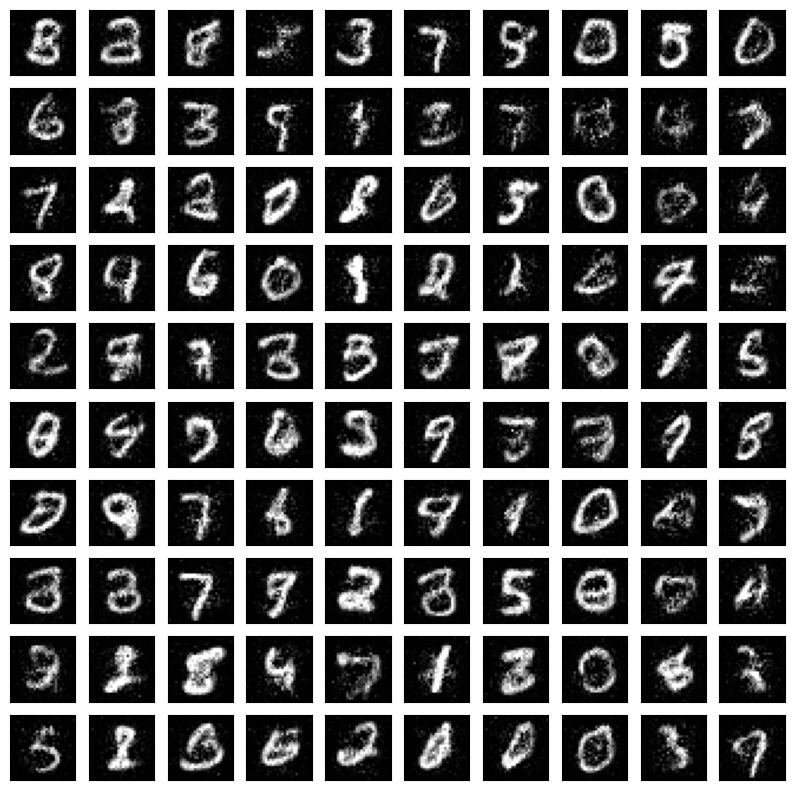

In [14]:
nb_data = 10
fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
for i in range(nb_data):
    for j in range(nb_data):
        x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.savefig('NF_Generated_MNIST_data.png')
plt.show()